In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from torch.special import gammaln

In [2]:
DEVICE = "cpu" # NOTE MacM2 processor is mps , cpu should be default  , if CUDA support and installed use cuda instead
SEED=3012024

In [3]:
torch.manual_seed(SEED)
# Based on https://github.com/AntixK/PyTorch-VAE/blob/master/models/lvae.py
def recompute_mean_var(mu1, mu2, log_var1, log_var2):
        # var^(-1)
        # print(mu1.shape, mu2.shape )
        var1 = (-log_var1).exp() 
        var2 = (-log_var2).exp()

        mu = (mu1 * var1 + mu2 * var2)/(var1 + var2)
        log_var = -torch.log(var1 + var2)
        return mu, log_var

class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        in_dim, hid1_dim, hid2_dim, mu_dim = dim
        # self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        # self.enc_h = nn.Linear(hidden_dims[0], data_dim)
        # self.enc_mu = nn.Linear(data_dim, hidden_dims[2])
        # self.enc_sigma = nn.Linear(data_dim, hidden_dims[2])
        self.in_layer = nn.Linear(in_dim, hid1_dim)
        self.enc_h = nn.Linear(hid1_dim, hid2_dim)
        self.enc_mu = nn.Linear(hid2_dim, mu_dim)
        self.enc_sigma = nn.Linear(hid2_dim, mu_dim)

    def forward(self, x):
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return h2, self.enc_mu(h2), F.softplus(self.enc_sigma(h2))
    
class Ladder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        in_dim, hid1_dim, hid2_dim, mu_dim = dim

        # self.in_layer = nn.Linear(hidden_dims[2], hidden_dims[-2])
        # self.enc_h = nn.Linear(hidden_dims[-2], hidden_dims[2])
        # self.enc_mu = nn.Linear(hidden_dims[2], hidden_dims[2])
        # self.enc_sigma = nn.Linear(hidden_dims[2], hidden_dims[2])
        self.in_layer = nn.Linear(in_dim, hid1_dim)
        self.enc_h = nn.Linear(hid1_dim, hid2_dim)
        self.enc_mu = nn.Linear(hid2_dim, mu_dim)
        self.enc_sigma = nn.Linear(hid2_dim, mu_dim)
    
    def forward(self, x):
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), F.softplus(self.enc_sigma(h2))

## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, ladder_dims, encoder_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        self.encoders = nn.Sequential(*[Encoder(dim) for dim in encoder_dims])

        self.ladders = nn.Sequential(*[Ladder(dim) for dim in ladder_dims])
        
        # hidden layer
        # define hidden and latent
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])

        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        params = []
        for encoder in self.encoders:
            x, mu, sigma = encoder(x)
            params.append((mu, sigma))
        return params

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor, params) -> torch.Tensor:
        kld = 0
        params.reverse()
        for i, ladder in enumerate(self.ladders):
            mu_p, logvar_p = ladder(z)
            mu_q, logvar_q = params[i]
            mu, logvar = recompute_mean_var(mu_q, mu_p, logvar_q, logvar_p)
            z  = self.reparameterize(mu, logvar)
            kld += self.compute_kl_divergence(mu, logvar, mu_q, logvar_q)
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4)), kld
    
    def sample(self, z):

        for ladder_block in self.ladders:
            mu, log_var = ladder_block(z)
            z = self.reparameterize(mu, log_var)

        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def compute_kl_divergence(self, mu_q, log_var_q, mu_p, log_var_p):

        # mu_q, log_var_q = q_params
        # mu_p, log_var_p = p_params
        

        kl = (log_var_p - log_var_q) + (log_var_q.exp() + (mu_q - mu_p)**2)/(2 * log_var_p.exp()) - 0.5
        kl = torch.sum(kl, dim = -1)
        return kl
        return -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        params = self.encode(x.view(-1, self.data_dim))
        mu, logvar = params.pop()
        self.params = params
        z = self.reparameterize(mu, logvar)
        return self.decode(z, params), mu, logvar

In [4]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BETA={ce:.2f} KLD={kld:.2f}")
            
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [6]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("mnist_train.csv", delimiter=",", dtype=np.float32, skiprows= 1)
mnist_test = np.loadtxt("mnist_test.csv", delimiter=",", dtype=np.float32, skiprows= 1)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 #NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

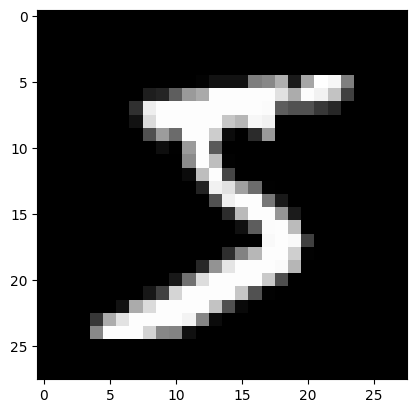

In [8]:
plt.imshow(train_data[0].reshape(28, 28), cmap = "gray")

In [9]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 256, 50, 300],
            encoder_dims= [
                (784, 784, 512, 256),
                (512, 256, 128, 128),
                (128, 64, 32, 64),
                (32, 16, 8, 32),
            ],
            ladder_dims=[
                (32, 2, 8, 64),
                (64, 16, 32, 128),
                (128, 64, 32, 256),
                # (256, 16, 8, 512),
            ]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def sumlogC(x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, clamp = -25) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    
    x = x.view(-1, 784)
    beta_term = 0
    recon_x, kld = recon_x
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum") 
    LOG_C = -sumlogC(recon_x) 
    KLD = torch.mean(kld)
    KLD2 = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD + LOG_C + KLD2, BCE, KLD # = -ELBO 

    return beta_term + KLD, beta_term, KLD # = -ELBO



In [10]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)
    plt.plot(np.arange(1, e+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
    plt.plot(np.arange(1, e+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss\n BCE+KLD")
    # plt.yscale("log")
    plt.title("VAE avrg. training loss per epoch")
    plt.legend()
    plt.savefig("current_error.png")
    plt.close()

Train epoch=1 [0/60000]	 loss=6.771889686584473
BETA=69600.95 KLD=199.39
Train epoch=1 [3200/60000]	 loss=-1139.663330078125
BETA=45648.59 KLD=898.52
Train epoch=1 [6400/60000]	 loss=-1199.1861572265625
BETA=39964.92 KLD=555.87
Train epoch=1 [9600/60000]	 loss=-1254.431396484375
BETA=39013.09 KLD=732.13
Train epoch=1 [12800/60000]	 loss=-1239.308837890625
BETA=40563.26 KLD=560.12
Train epoch=1 [16000/60000]	 loss=-1242.3101806640625
BETA=39859.47 KLD=492.53
Train epoch=1 [19200/60000]	 loss=-1287.1480712890625
BETA=40185.35 KLD=485.29
Train epoch=1 [22400/60000]	 loss=-1305.2220458984375
BETA=36745.59 KLD=414.21
Train epoch=1 [25600/60000]	 loss=-1341.6053466796875
BETA=33085.39 KLD=379.00
Train epoch=1 [28800/60000]	 loss=-1358.0966796875
BETA=34382.61 KLD=335.04
Train epoch=1 [32000/60000]	 loss=-1378.55078125
BETA=29232.21 KLD=312.93
Train epoch=1 [35200/60000]	 loss=-1393.0489501953125
BETA=30392.73 KLD=325.12
Train epoch=1 [38400/60000]	 loss=-1430.285888671875
BETA=29750.46 KLD=3

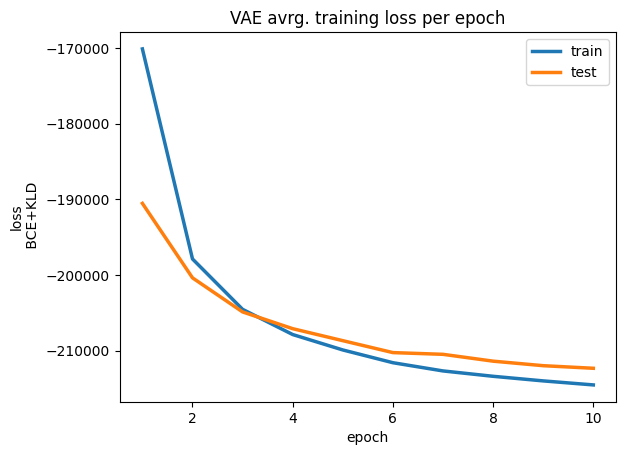

In [13]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [12]:
steps = 12
vals = torch.linspace(0.05, 0.95, steps=steps)
x, y = torch.meshgrid(vals, vals, indexing='xy')
z1 = torch.distributions.normal.Normal(0,1).icdf(x)
z2 = torch.distributions.normal.Normal(0,1).icdf(y)

reps = []
with torch.no_grad():
  for i in range(steps):
    for j in range(steps):
      z = torch.tensor([z1[i, j], z2[i, j]])
      x =model.sample(z) 
      reps.append(x.reshape(28, 28))




RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 32x2)

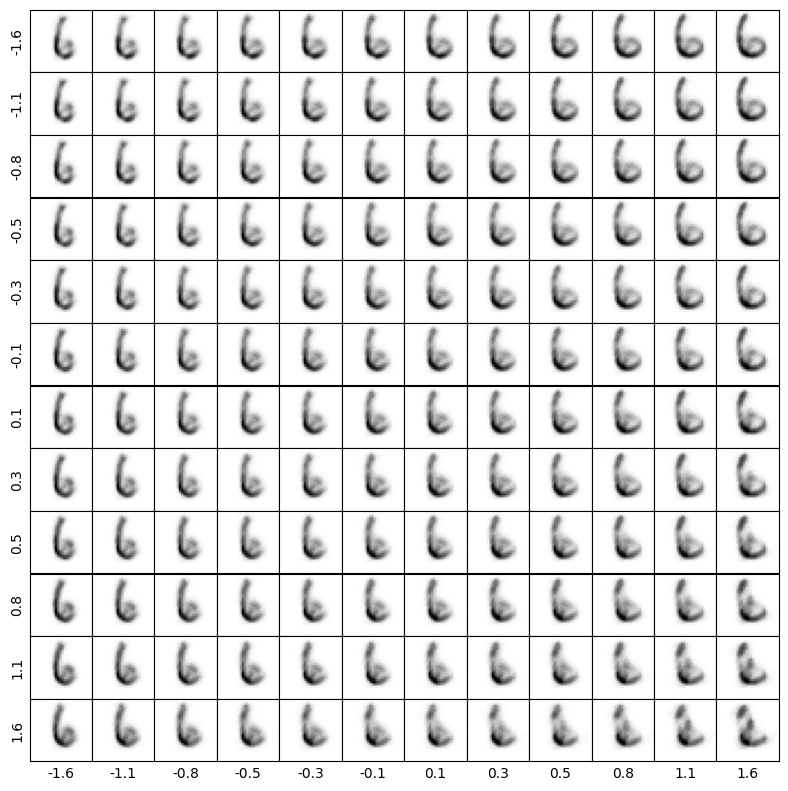

In [ ]:
fig, ax = plt.subplots(nrows = steps, ncols = steps, figsize=(8,8), gridspec_kw = {'wspace':0, 'hspace':0, })
for i in range(steps):
  for j in range(steps):
    n = i * steps + j
    ax[i, j].imshow(reps[n], cmap ="Greys")
    if j == 0:
      ax[i, j].set_ylabel(f"{z2[i,j].item():.1f}")
    if i == steps - 1:
      ax[i, j].set_xlabel(f"{z1[i,j].item():.1f}")

plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig("Bern_output_continuous.jpg")

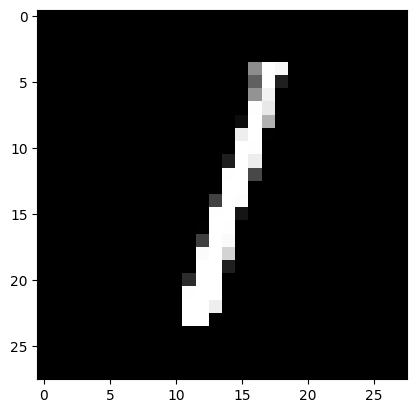

In [14]:
with torch.no_grad():
    x, kdl = model(torch.tensor(test_data[2]))[0]
    plt.imshow(x.reshape(28, 28), cmap = "gray")

In [15]:
diffs = []

for img in test_data:
    img = torch.tensor(img)
    x, kld = model(img)[0]
    diffs.append(torch.mean((img - x) ** 2).item())

In [16]:
np.mean(diffs)

0.012406986136571504

In [17]:
num = 50
fig, ax = plt.subplots(nrows = num, ncols = 2, figsize=(8,num), gridspec_kw = {'wspace':0.5, 'hspace':0, }, dpi = 1200)
with torch.no_grad():
    for i in range(num):
        img = torch.tensor(test_data[i])
        ax[i, 0].imshow(img.reshape(28, 28), cmap = "gray")
        x, kld = model(img)[0]
        ax[i, 1].imshow(x.reshape(28, 28), cmap = "gray")
        

ax[0, 0].set_title("Original")
ax[0, 1].set_title("LVAE")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

[]

In [ ]:
def sample2(self, z):
    # for ladder_block in self.ladders:
    #     mu, log_var = ladder_block(z)
    #     z = self.reparameterize(mu, log_var)
    #     print(z)
    h3 = F.relu(self.dec_h(z))
    h4 = F.relu(self.dec_layer(h3))
    return torch.sigmoid(self.out_layer(h4))


In [ ]:
VAE.sample = sample2